## Abstract

In this blog post, we expand upon our previous implementation of logistic regression to add another optimization option.
In our updated implementation of logistic regression, available at [logistic.py](logistic.py), we can now optimize our logistic regression model with both gradient descent (with momentum) and Newton's method.
After implementing this extension, we demonstrate with an example that logistic regression with both optimizers converges to the same solution.
Using the same example, we reveal that logistic regression with Newton's method commonly converges to a solution in fewer training iterations than gradient descent.
We also illustrate that selecting an appropriate value for $\alpha$ is critical to Newton's method, as the optimizer will not converge to a solution if $\alpha$ is too large.
Finally, we count the number of operations required in each iteration of model training for both gradient descent and Newton's method, revealing that Newton's method is more computationally expensive than gradient descent, especially when working with many features.

## Generating Training Data

First, we import the packages we will need for this assignment.

In [1]:
# Import packages
%load_ext autoreload
%autoreload 2
from logistic import LogisticRegression, GradientDescentOptimizer, NewtonOptimizer
import torch
from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

Next, we generate the data that we will use to train our model.
Thank you to Professor Chodrow for providing the functions for generating and visualizing training data.

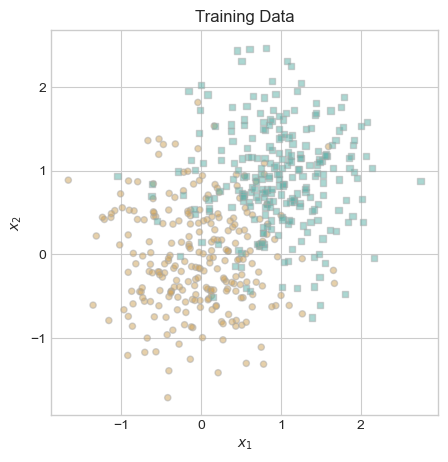

In [2]:
# define function to generate data
def classification_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    return X, y

# define function to plot data
def plot_data(X, y, ax):
    assert X.shape[1] == 3, "This function only works for data created with p_dims == 2"
    targets = [0, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = y[ix], facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -0.5, vmax = 1.5, alpha = 0.5, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

# set seed
torch.manual_seed(1234)

# generate data
X, y = classification_data(n_points = 500, noise = 0.6)

# plot data
fig, ax = plt.subplots(figsize = (5, 5))
plot_data(X, y, ax)
ax.set_title("Training Data");

## Convergence to an Appropriate Decision Boundary

To begin evaluating the efficacy of our model, we fit logistic regression on our training data with regular gradient descent and with Newton's method, illustrating that both options converge to the same solution.

In [3]:
# set seed
torch.manual_seed(1234)

# initialize logistic regression model and gradient descent optimizer
LR_gradient = LogisticRegression() 
opt_gradient = GradientDescentOptimizer(LR_gradient)

# initialize vector to record loss values
loss_vec_gradient = [10, 5]

# fit model
while loss_vec_gradient[-2] - loss_vec_gradient[-1] > 0.00001:

    # update model
    opt_gradient.step(X, y, alpha = 0.07, beta = 0)

    # calculate and record loss
    loss = LR_gradient.loss(X, y) 
    loss_vec_gradient.append(loss)

# remove initialization values
loss_vec_gradient = loss_vec_gradient[2:]

# reset seed
torch.manual_seed(1234)

# initialize logistic regression model and newton's optimizer
LR_newton = LogisticRegression() 
opt_newton = NewtonOptimizer(LR_newton)

# initialize vector to record loss values
loss_vec_newton = [10, 5]

# fit model
while loss_vec_newton[-2] - loss_vec_newton[-1] > 0.00001:

    # update model
    opt_newton.step(X, y, alpha = 10)

    # calculate and record loss
    loss = LR_newton.loss(X, y) 
    loss_vec_newton.append(loss)

# remove initialization values
loss_vec_newton = loss_vec_newton[2:]

Now that we have fit our models, let's inspect the decision boundaries in the context of our training data.

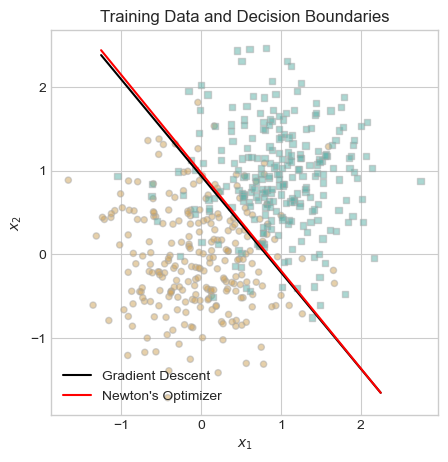

In [4]:
# define function to draw line
def draw_line(w, x_min, x_max, ax, **kwargs):
    w_ = w.flatten()
    x = torch.linspace(x_min, x_max, 101)
    y = -(w_[0]*x + w_[2])/w_[1]
    l = ax.plot(x, y, **kwargs)

# plot decision boundary
fig, ax = plt.subplots(figsize = (5, 5))
plot_data(X, y, ax)
draw_line(LR_gradient.w, x_min = -1.25, x_max = 2.25, ax = ax, color = "black", label = "Gradient Descent")
draw_line(LR_newton.w, x_min = -1.25, x_max = 2.25, ax = ax, color = "red", label = "Newton's Optimizer")
ax.legend(loc = "lower left")
ax.set_title("Training Data and Decision Boundaries");

The decision boundaries for the gradient descent optimizer and Newton's optimizer are virtually identical!
This result makes me confident that we have correctly implemented logistic regression with Newton's optimizer.

## The Speed of Newton's Optimizer

In the previous section we saw that logistic regression with gradient descent and Newton's method converge to the same solution.
Naturally, one might wonder whether both options approach the solution at the same rate.
As it turns out, when an appropriate value of $\alpha$ is selected, logistic regression with Newton's optimizer converges to a solution in far fewer iterations than logistic regression with classic gradient descent.
To illustrate this statement, we plot the change in loss over the iterations of both models' training.

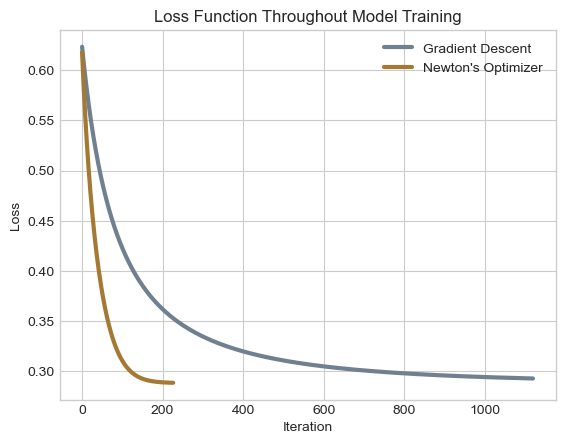

In [5]:
# plot the changes in loss 
plt.plot(loss_vec_gradient, color = "slategrey", lw = 3, label = "Gradient Descent")
plt.plot(loss_vec_newton, color = "#A37933", lw = 3, label = "Newton's Optimizer")
labs = plt.gca().set(xlabel = "Iteration", ylabel = "Loss")
plt.legend(loc = "upper right")
plt.title("Loss Function Throughout Model Training");

As we would expect, the two optimizers begin with identical loss values.
However, from the very beginning, the loss values of logistic regression with Newton's optimizer decrease more rapidly than logistic regression with gradient descent.
In fact, Newton's approach achieves an incremental improvement to the loss function of less than our threshold of $0.00001$ in just over $200$ iterations, whereas the gradient descent approach requires over $1,100$ iterations.
For this data and this choice of $\alpha$, the Newton's optimizer approach requires dramatically fewer iterations than regular gradient descent.

## When $\alpha$ is Too Large

The learning rate $\alpha$ impacts how far logistic regression with Newton's method moves the decision boundary in any given iteration.
When $\alpha$ is very small, each change to the decision boundary becomes similarly small, such that it takes many iterations to converge to an adequate solution.
In the example above, $\alpha$ was large enough that logistic regression with Newton's optimizer converged to a solution more rapidly than ordinary gradient descent.
But what happens when $\alpha$ is substantially larger?
To answer this question, we experiment with fitting a model where $\alpha = 10,000$ in the code chunk below.

In [6]:
# reset seed
torch.manual_seed(1234)

# initialize logistic regression model and newton's optimizer
LR_newton_10000 = LogisticRegression() 
opt_newton_10000 = NewtonOptimizer(LR_newton_10000)

# initialize vector to record loss values
loss_vec_newton_10000 = [10, 5]

# initialize counter
counter = 0

# fit model
while loss_vec_newton_10000[-2] - loss_vec_newton_10000[-1] > 0.00001:
    # update model
    opt_newton_10000.step(X, y, alpha = 10000)

    # calculate and record loss
    loss = LR_newton_10000.loss(X, y) 
    loss_vec_newton_10000.append(loss)
    
    # update counter
    counter += 1

# remove initialization values
loss_vec_newton_10000 = loss_vec_newton_10000[2:]

# print results
print("Total iterations:", counter, "\nResulting loss vector", loss_vec_newton_10000)

Total iterations: 1 
Resulting loss vector [tensor(nan)]


Apparently, by increasing $\alpha$ to $10,000$, we prevented the logistic regression model with Newton's optimizer from converging to a solution.
In fact, with $\alpha$ set so high, the model produces a loss value of `NaN`, terminating our training loop in a single iteration.
This likely occured because the large value of $\alpha$ caused the decision boundary to move so far that the loss function's value exceeded the maximum value that torch can store.

## Operation Counting

Let $C_{gd}$ represent the total computational cost of fitting a logistic regression model with gradient descent and $C_{nm}$ represent the total computational cost of fitting a logistic regression model with Newton's method.

Suppose that gradient descent converges to an adequate solution in $t_{gd}$ iterations and Newton's method converges to an adequate solution in $t_{nm}$ iterations.
Furthermore, per Professor Chodrow's instructions, we assume that the following operations are associated with the following computational costs.

- Computing the loss: $c$ computational units
- Computing the gradient: $2c$ units 
- Computing the Hessian: $pc$ units
- Inverting a $p \times p$ matrix: $k_1p^\gamma$ units
- Performing the matrix-vector multiplication required by Newton's method: $k_2p^2$

In each iteration of gradient descent, we calculate the loss and the gradient once, leading to the following total computational cost.

$C_{gd} = t_{gd} (c + 2c) = t_{gd}(3c)$

In each iteration of Newton's method, we calculate the loss, Hessian, inverse Hessian, matrix multiplication, and gradient once, leading to the following total computational cost.

$C_{nm} = t_{nm}(c + pc + k_1p^\gamma + k_2p^2 + 2c) = t_{nm}(3c + pc + k_1p^\gamma + k_2p^2)$

If Newton's method requires fewer computational units to complete than gradient descent, we have the following inequalities.

$$C_{nm} < C_{gd}$$ 
$$t_{nm}(3c + pc + k_1p^\gamma + k_2p^2) < t_{gd}(3c)$$
$$\frac{(3c + pc + k_1p^\gamma + k_2p^2)}{3c} < \frac{t_{gd}}{t_{nm}}$$

Thus, Newton's method will only require less computational effort than gradient descent if the total number of iterations required to complete gradient descent $t_{gd}$ is at least $\frac{(3c + pc + k_1p^\gamma + k_2p^2)}{3c}$ times as much as the number of iterations required to complete Newton's method.

Since $p$ is raised to the power of $2$ and to the power of $\gamma$ in this formula, the ratio between $t_{gd}$ and $t_{nm}$ required for Newton's method to be more efficient than gradient descent increases dramatically as $p$ increases.
Practically speaking, when working with datasets of many variables, this is unlikely to happen.
For this reason, if working on a dataset with many variables, gradient descent will almost certainly be more efficient than Newton's method.

## Conclusion

Completing this assignment gave me the opportunity to understand the strengths and weaknesses of two different optimization methods for logistic regression.
By implementing and performing experiments with both gradient descent and Newton's method, I learned that Newton's method may converge to an adequate solution in fewer training iterations than gradient descent.
By counting the number of operations required for both optimizers, I discovered that fewer iterations does not necessarily mean lower computational complexity.
In fact, when working with a large number of features, gradient descent is almost certainly less computationally expensive than Newton's method.
In summary, if given the choice between gradient descent and Newton's method, choose gradient descent!